<a href="https://colab.research.google.com/github/Sagnik-Nandi/PDFQueryBot---Chatbot-over-PDFs-using-RAG/blob/main/assnmt%202%20-%20Sentiment%20Classifier/sentiment_classifier_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

np.random.seed(42)
tf.random.set_seed(42)

#Load the IMDB dataset
The dataset comes pre-processed, where reviews are sequences of integers
(word indices). num_words specifies the maximum number of words to keep,
based on word frequency.


In [7]:
MAX_WORDS = 10000  # Only consider the top MAX_WORDS most frequent words
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=MAX_WORDS)

print(f"Original training set size: {len(x_train_full)} reviews")
print(f"Original test set size: {len(x_test)} reviews")
print(f"Example review (first 10 words of first review): {x_train_full[0][:10]}")
print(f"Example label (first review): {y_train_full[0]}") # 0 for negative, 1 for positive

Original training set size: 25000 reviews
Original test set size: 25000 reviews
Example review (first 10 words of first review): [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
Example label (first review): 1


In [8]:
word_index = tf.keras.datasets.imdb.get_word_index()
# Create a reverse word index (integer to word) for decoding reviews
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Helper function to decode a review
def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text])
    # The first 3 indices are reserved for padding, start-of-sequence, and unknown.
    # So, we add 3 to the index to get the actual word.

print(f"Decoded example review: {decode_review(x_train_full[0])[:200]}...")



Decoded example review: ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the sa...


In [10]:
num_examples_to_print = 5

print("\nTraining Set Examples:")
for i in range(num_examples_to_print):
    review_text = decode_review(x_train_full[i])
    sentiment_label = "Positive" if y_train_full[i] == 1 else "Negative"
    print(f"Review {i+1} (Label: {sentiment_label}):")
    print(f"  {review_text[:300]}...")
    print("-" * 50)


Training Set Examples:
Review 1 (Label: Positive):
  ? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there wa...
--------------------------------------------------
Review 2 (Label: Negative):
  ? big hair big boobs bad music and a giant safety pin these are the words to best describe this terrible movie i love cheesy horror movies and i've seen hundreds but this had got to be on of the worst ever made the plot is paper thin and ridiculous the acting is an abomination the script is complete...
--------------------------------------------------
Review 3 (Label: Negative):
  ? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an h

# Train test validation split

In [21]:

# Define maximum sequence length for padding
# Reviews shorter than MAX_LEN will be padded, longer reviews will be truncated.
MAX_LEN = 256

# Padding
x_train_padded = tf.keras.preprocessing.sequence.pad_sequences(x_train_full,
                                                               maxlen=MAX_LEN,
                                                               padding='post',
                                                               truncating='post')
x_test_padded = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                              maxlen=MAX_LEN,
                                                              padding='post',
                                                              truncating='post')

print(f"Example padded review (first 10 elements): {decode_review(x_train_padded[0][:10])}")


Example padded review (first 10 elements): ? this film was just brilliant casting location scenery story


In [12]:
VALIDATION_SPLIT = 0.2
validation_samples = int(len(x_train_full) * VALIDATION_SPLIT)

x_val = x_train_padded[:validation_samples]
y_val = y_train_full[:validation_samples]

x_train = x_train_padded[validation_samples:]
y_train = y_train_full[validation_samples:]

print(f"Training set size after split: {len(x_train)} reviews")
print(f"Validation set size: {len(x_val)} reviews")


Training set size after split: 20000 reviews
Validation set size: 5000 reviews


##Model Architecture (LSTM)

In [13]:
# Define the embedding dimension
EMBEDDING_DIM = 128

# Model architecture : embedding - LSTM - Dense
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=MAX_WORDS,
                              output_dim=EMBEDDING_DIM,
                              input_length=MAX_LEN),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# model.summary()


# Training

In [15]:
EPOCHS = 10
BATCH_SIZE = 32

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=2,
    mode='max',
    restore_best_weights=True,
    verbose=1 # Shows messages when stopping
)

print("\nStarting model training...")
history = model.fit(x_train, y_train,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    callbacks=[early_stopping_callback],
                    verbose=1) # verbose=1 shows a progress bar

print("\nModel training finished.")



Starting model training...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 176ms/step - accuracy: 0.5043 - loss: 0.6932 - val_accuracy: 0.5234 - val_loss: 0.6875
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 113s 181ms/step - accuracy: 0.5573 - loss: 0.6677 - val_accuracy: 0.5490 - val_loss: 0.6817
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 179ms/step - accuracy: 0.6157 - loss: 0.6103 - val_accuracy: 0.8042 - val_loss: 0.4959
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 185ms/step - accuracy: 0.8633 - loss: 0.3524 - val_accuracy: 0.8612 - val_loss: 0.3563
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 183ms/step - accuracy: 0.9233 - loss: 0.2084 - val_accuracy: 0.8646 - val_loss: 0.3906
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 114s 183ms/step - accuracy: 0.9536 - loss: 0.1432 - val_accuracy: 0.8498 - val_loss: 0.5050
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 192ms/step - accuracy: 0.9684 - loss: 0.1060 - val_accuracy: 0.8562 - val_loss: 0.5050
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 178

# Testing

In [16]:
print("\nEvaluating model on the test set...")
test_loss, test_accuracy = model.evaluate(x_test_padded, y_test, verbose=2)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")



Evaluating model on the test set...
782/782 - 35s - 45ms/step - accuracy: 0.8426 - loss: 0.6814

Test Loss: 0.6814
Test Accuracy: 0.8426


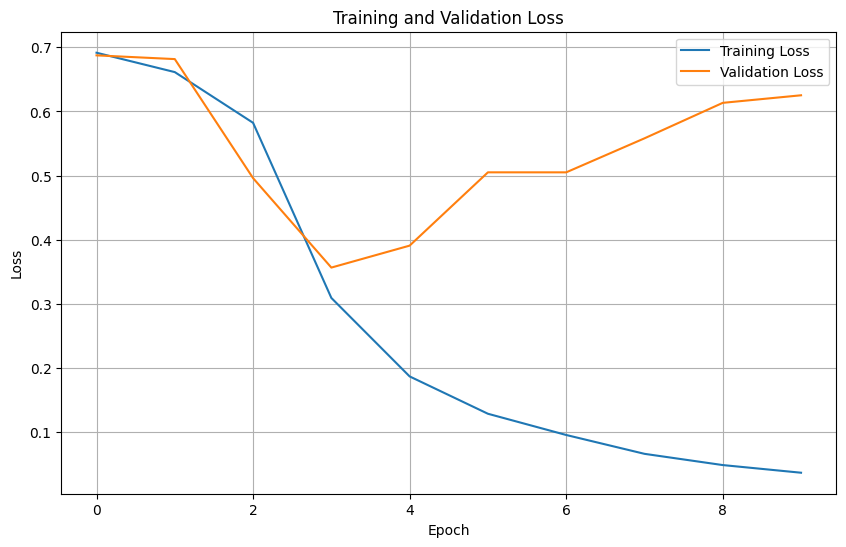

In [17]:
# Get training and validation loss from history
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

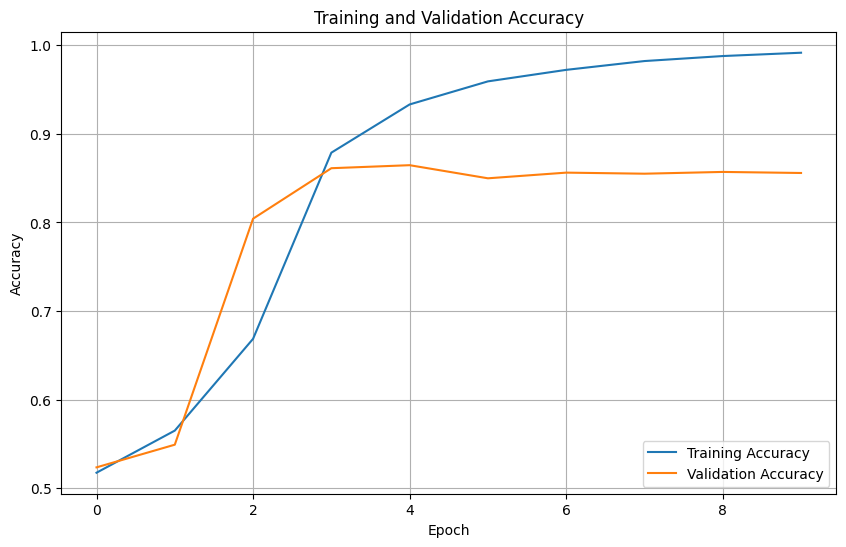

In [18]:
# Optional: Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
